In [36]:
from pymarketng.application.Mechanism import Average_Mechanism,Average_Mechanism_Multi, Macafee_mechanism, TradeReduction_mechanism, VCG_Mechanism
from pymarketng.application.BidManager import BidManager
from pymarketng.application.Plot import plot_demand_curves, plot_trades_as_graph

from pymarketng.domain.Bid import Bid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np


### Load Dataset

In [5]:
df = pd.read_csv('final_df.csv')
df

,time,type_user0,load_user0,generate_user0,SOC_user0,unit_user0,price_user0,is_seller_user0,is_peak_user0,type_user1,...,type_user26,load_user26,unit_user26,price_user26,is_peak_user26,type_user27,load_user27,unit_user27,price_user27,is_peak_user27
0,4/5/2013 0:00,3,401,0.0,0.0,401.0,9.486745,False,False,3,...,1,52,52,0.940167,False,1,250,250,5.908710,False
1,4/5/2013 1:00,3,374,0.0,0.0,374.0,4.361242,False,False,3,...,1,188,188,4.469316,False,1,235,235,5.424288,False
2,4/5/2013 2:00,3,511,0.0,0.0,511.0,14.258272,False,False,3,...,1,117,117,2.437663,False,1,235,235,5.770687,False
3,4/5/2013 3:00,3,370,0.0,0.0,370.0,8.002181,False,False,3,...,1,53,53,0.870651,False,1,197,197,3.058945,False
4,4/5/2013 4:00,3,281,0.0,0.0,281.0,6.388507,False,False,3,...,1,46,46,1.228715,False,1,171,171,1.710000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,4/7/2013 19:00,3,634,0.0,0.0,634.0,80.101007,False,True,3,...,1,108,108,12.424508,True,1,1382,1382,153.362647,True
68,4/7/2013 20:00,3,855,0.0,0.0,855.0,109.916275,False,True,3,...,1,123,123,14.104958,True,1,754,754,82.977889,True
69,4/7/2013 21:00,3,1329,0.0,0.0,1329.0,183.361862,False,True,3,...,1,160,160,19.200000,True,1,744,744,80.506533,True
70,4/7/2013 22:00,3,922,0.0,0.0,922.0,9.560336,False,False,3,...,1,306,306,6.431619,False,1,847,847,12.059464,False


### Create df for each user

In [16]:
users_type1=[]
users_type2=[]
users_type3=[]
for i in range(0,28):
    if df[f'type_user{i}'][0] == 3:
        user_dict_type3= {
            "time":df['time'],
            "Is_Peak":df[f'is_peak_user{i}'],
            "Load":df[f'load_user{i}'],
            "Generate":df[f'generate_user{i}'],
            "SOC":df[f'SOC_user{i}'],
            "Unit":df[f'unit_user{i}'],
            "Price":df[f'price_user{i}'],
            "Is_Seller":df[f'is_seller_user{i}'],
            "User": i
        }
        users_type3.append(pd.DataFrame(user_dict_type3))
    elif df[f'type_user{i}'][0] == 2:
        user_dict_type2= {
            "time":df['time'],
            "Is_Peak":df[f'is_peak_user{i}'],
            "Load":df[f'load_user{i}'],
            "Generate":df[f'generate_user{i}'],
            "Unit":df[f'unit_user{i}'],
            "Price":df[f'price_user{i}'],
            "Is_Seller":df[f'is_seller_user{i}'],
            "User": i
        }
        users_type2.append(pd.DataFrame(user_dict_type2))

    elif df[f'type_user{i}'][0] == 1:
        user_dict_type1= {
            "time":df['time'],
            "Is_Peak":df[f'is_peak_user{i}'],
            "Load":df[f'load_user{i}'],
            "Unit":df[f'unit_user{i}'],
            "Price":df[f'price_user{i}'],
            "User": i,
            "Is_Seller": False
        }

        users_type1.append(pd.DataFrame(user_dict_type1))


### conver list to pd and save as a csv file

In [18]:

df_Type1 = pd.concat(users_type1)
df_Type2 = pd.concat(users_type2)
df_Type3 = pd.concat(users_type3)

df_Type1.to_csv('users_type1.csv', index=False)
df_Type2.to_csv('users_type2.csv', index=False)
df_Type3.to_csv('users_type3.csv', index=False)         


### detect ruonds

In [6]:
bm = BidManager()

bm.add_bid(Bid(10.0, 0,))
bm.add_bid(Bid(20.0, 1))
bm.add_bid(Bid(30.0, 2))
bm.add_bid(Bid(55.0, 9))
bm.add_bid(Bid(56.0, 10))
bm.add_bid(Bid(57.0, 11))
bm.add_bid(Bid(58.0, 12))
bm.add_bid(Bid(59.0, 13))
bm.add_bid(Bid(41.0, 15, buying=False))
bm.add_bid(Bid(42.0, 16, buying=False))
bm.add_bid(Bid(45.0, 20, buying=False))
bm.add_bid(Bid(51.0, 21, buying=False))
bm.add_bid(Bid(52.0, 22, buying=False))
bm.add_bid(Bid(53.0, 23, buying=False))
bm.add_bid(Bid(58.0, 24, buying=False))


bm.get_breakeven_index()

4

In [23]:
bm = BidManager()
# if df_Type1['time'] == "04/05/2013  12:00:00 ق.ظ":
# for i in range (0,10):
    # bm.add_bid(Bid(price= df_Type1['Price'],   quantity= df_Type1['Unit'] , buying= df_Type1['Is_Seller']))
df_Type3_filtered = df_Type3[df_Type3['time'] == '4/5/2013 7:00']
df_Type2_filtered = df_Type2[df_Type2['time'] == '4/5/2013 7:00']
df_Type1_filtered = df_Type1[df_Type1['time'] == '4/5/2013 7:00']
# Concatenate the filtered data frames into a new data frame
df_round1 = pd.concat([df_Type3_filtered, df_Type2_filtered, df_Type1_filtered], ignore_index=True)

for index , row  in df_round1.iterrows():
    # print(row)
    bm.add_bid(Bid(user=row['User'],price=row['Price'], quantity= row['Unit'], buying=not row['Is_Seller'],time= row['time']))

bm.get_df()

,quantity,remaining_quantity,price,user,buying,time,divisible
0,185.241129,185.241129,5.100347,0,True,4/5/2013 7:00,True
1,755.379032,755.379032,19.082587,1,True,4/5/2013 7:00,True
2,93.103225,93.103225,1.483685,2,True,4/5/2013 7:00,True
3,465.241129,465.241129,4.738278,6,True,4/5/2013 7:00,True
4,459.241129,459.241129,10.327175,7,True,4/5/2013 7:00,True
5,122.241129,122.241129,2.512734,8,True,4/5/2013 7:00,True
6,777.379032,777.379032,19.460388,10,True,4/5/2013 7:00,True
7,18.103225,18.103225,0.377833,11,True,4/5/2013 7:00,True
8,4203.654838,4203.654838,109.534832,12,True,4/5/2013 7:00,True
9,75.103225,75.103225,2.106957,14,True,4/5/2013 7:00,True


In [37]:
m=bm.run(Average_Mechanism_Multi)
m.get_df()

""


## Mechanism selection 

## Activity of netwoeks

### calculate number of participant

In [24]:

def calculate_number_participants(df):
    return len(df['User'].unique())


sum_participant_dict= {}
time_list = df_Type2['time'].unique()

participant_dict3 = {}
participant_dict2 = {}
participant_dict1 = {}

for round_time in time_list:
    filtered_df_type3 = df_Type3[(df_Type3['time'] == round_time) & (df_Type3['Unit'] != 0)]
    unique_users3 = filtered_df_type3['User'].unique()
    num_participants3 = len(unique_users3)
    participant_dict3[round_time] = num_participants3

    filtered_df_type2 = df_Type2[(df_Type2['time'] == round_time) & (df_Type2['Unit'] != 0)]
    unique_users2 = filtered_df_type2['User'].unique()
    num_participants2 = len(unique_users2)
    participant_dict2[round_time] = num_participants2

    filtered_df_type1 = df_Type1[(df_Type1['time'] == round_time) & (df_Type1['Unit'] != 0)]
    unique_users1 = filtered_df_type1['User'].unique()
    num_participants1 = len(unique_users1)
    participant_dict1[round_time] = num_participants1
    sum_participant_dict[round_time] = num_participants1 + num_participants2 + num_participants3 

sum_participant_dict


{'4/5/2013 0:00': 27,
 '4/5/2013 1:00': 28,
 '4/5/2013 2:00': 28,
 '4/5/2013 3:00': 28,
 '4/5/2013 4:00': 28,
 '4/5/2013 5:00': 28,
 '4/5/2013 6:00': 28,
 '4/5/2013 7:00': 24,
 '4/5/2013 8:00': 22,
 '4/5/2013 9:00': 18,
 '4/5/2013 10:00': 18,
 '4/5/2013 11:00': 18,
 '4/5/2013 12:00': 18,
 '4/5/2013 13:00': 27,
 '4/5/2013 14:00': 27,
 '4/5/2013 15:00': 28,
 '4/5/2013 16:00': 28,
 '4/5/2013 17:00': 23,
 '4/5/2013 18:00': 26,
 '4/5/2013 19:00': 28,
 '4/5/2013 20:00': 28,
 '4/5/2013 21:00': 28,
 '4/5/2013 22:00': 28,
 '4/5/2013 23:00': 28,
 '4/6/2013 0:00': 28,
 '4/6/2013 1:00': 28,
 '4/6/2013 2:00': 28,
 '4/6/2013 3:00': 28,
 '4/6/2013 4:00': 28,
 '4/6/2013 5:00': 28,
 '4/6/2013 6:00': 28,
 '4/6/2013 7:00': 22,
 '4/6/2013 8:00': 19,
 '4/6/2013 9:00': 19,
 '4/6/2013 10:00': 18,
 '4/6/2013 11:00': 17,
 '4/6/2013 12:00': 19,
 '4/6/2013 13:00': 27,
 '4/6/2013 14:00': 28,
 '4/6/2013 15:00': 28,
 '4/6/2013 16:00': 27,
 '4/6/2013 17:00': 23,
 '4/6/2013 18:00': 24,
 '4/6/2013 19:00': 28,
 '4/6/20

### compare each round with its perivious round 

In [25]:
## To Do how can we calculate threshhold
alpha_percent = 0.8  
for round_time in time_list:
    current_participants = sum_participant_dict[round_time]
    previous_round = time_list.tolist()[time_list.tolist().index(round_time) - 1]
    previous_participants = sum_participant_dict[previous_round]
    threshold = alpha_percent * previous_participants
    if current_participants >= threshold:
        print(sum_participant_dict[round_time], round_time,  "There is a significant increase in participants compared to the previous round.")
    else:
        print(sum_participant_dict[round_time], round_time , "There is a significant decrease in participants compared to the previous round.")


27 4/5/2013 0:00 There is a significant increase in participants compared to the previous round.
28 4/5/2013 1:00 There is a significant increase in participants compared to the previous round.
28 4/5/2013 2:00 There is a significant increase in participants compared to the previous round.
28 4/5/2013 3:00 There is a significant increase in participants compared to the previous round.
28 4/5/2013 4:00 There is a significant increase in participants compared to the previous round.
28 4/5/2013 5:00 There is a significant increase in participants compared to the previous round.
28 4/5/2013 6:00 There is a significant increase in participants compared to the previous round.
24 4/5/2013 7:00 There is a significant increase in participants compared to the previous round.
22 4/5/2013 8:00 There is a significant increase in participants compared to the previous round.
18 4/5/2013 9:00 There is a significant increase in participants compared to the previous round.
18 4/5/2013 10:00 There is a s

### Calculate number of units

In [28]:
def calculate_number_participants(df):
    return len(df['User'].unique())

sum_unit_dict= {}
# time_list = df_Type2['time'].unique()
unit_dict1 = {}
unit_dict2 = {}
unit_dict3 = {}

for round_time in time_list:
    filtered_df_type3 = df_Type3[(df_Type3['time'] == round_time)]
    unique_users3 = filtered_df_type3['User'].unique()
    num_units_buyer3 = filtered_df_type3[filtered_df_type3['Is_Seller'] == False]['Unit'].sum()
    num_units_seller3 = filtered_df_type3[filtered_df_type3['Is_Seller'] == True]['Unit'].sum()
    sum_units3 = num_units_buyer3 + num_units_seller3
    unit_dict3[round_time] = [num_units_buyer3 , num_units_seller3 , sum_units1]

    filtered_df_type2 = df_Type2[(df_Type2['time'] == round_time)]
    unique_users2 = filtered_df_type2['User'].unique()
    num_units_buyer2 = filtered_df_type2[filtered_df_type2['Is_Seller'] == False]['Unit'].sum()
    num_units_seller2 = filtered_df_type2[filtered_df_type2['Is_Seller'] == True]['Unit'].sum()
    sum_units2 = num_units_buyer2 + num_units_seller2
    unit_dict2[round_time] = [num_units_buyer2 , num_units_seller2 , sum_units2]

    filtered_df_type1 = df_Type1[(df_Type1['time'] == round_time)]
    unique_users1 = filtered_df_type1['User'].unique()
    num_units_buyer1 = filtered_df_type1[filtered_df_type1['Is_Seller'] == False]['Unit'].sum()
    num_units_seller1 = filtered_df_type1[filtered_df_type1['Is_Seller'] == True]['Unit'].sum()
    sum_units1 = num_units_buyer1 + num_units_seller1
    unit_dict1[round_time] = [num_units_buyer1 , num_units_seller1 , sum_units1]

    num_units_buyers = num_units_buyer1+num_units_buyer2 + num_units_buyer3
    num_units_sellers = num_units_seller1+num_units_seller2 + num_units_seller3
    sum_units = sum_units1+sum_units2+ sum_units3 
    diff_units = abs(num_units_buyers - num_units_sellers)

    sum_unit_dict[round_time] = {'num_units_buyers':num_units_buyers , 'num_units_sellers':num_units_sellers, 'sum_units':sum_units,'diff_units':diff_units}
     
sum_unit_dict


{'4/5/2013 0:00': {'num_units_buyers': 13016.0,
  'num_units_sellers': 0.0,
  'sum_units': 13016.0,
  'diff_units': 13016.0},
 '4/5/2013 1:00': {'num_units_buyers': 13329.0,
  'num_units_sellers': 0.0,
  'sum_units': 13329.0,
  'diff_units': 13329.0},
 '4/5/2013 2:00': {'num_units_buyers': 18817.0,
  'num_units_sellers': 0.0,
  'sum_units': 18817.0,
  'diff_units': 18817.0},
 '4/5/2013 3:00': {'num_units_buyers': 23699.0,
  'num_units_sellers': 0.0,
  'sum_units': 23699.0,
  'diff_units': 23699.0},
 '4/5/2013 4:00': {'num_units_buyers': 18640.0,
  'num_units_sellers': 0.0,
  'sum_units': 18640.0,
  'diff_units': 18640.0},
 '4/5/2013 5:00': {'num_units_buyers': 18365.0,
  'num_units_sellers': 0.0,
  'sum_units': 18365.0,
  'diff_units': 18365.0},
 '4/5/2013 6:00': {'num_units_buyers': 18651.0,
  'num_units_sellers': 0.0,
  'sum_units': 18651.0,
  'diff_units': 18651.0},
 '4/5/2013 7:00': {'num_units_buyers': 16155.720962230002,
  'num_units_sellers': 510.13871109,
  'sum_units': 16665.8

### Compare each number of units with its average from start to current round_time

In [29]:
## To Do how can we calculate threshhold
alpha_percent = 0.8
return_zero_if_negative = lambda x: 0 if x < 0 else x
moving_average_period=5
for i,round_time in enumerate(time_list):
    sum_previous_units = np.mean([sum['sum_units'] for sum in sum_unit_dict.values()][return_zero_if_negative(i-moving_average_period):i+1])
    print(sum_previous_units , i)
# sum_previous_units

13016.0 0
13172.5 1
15054.0 2
17215.25 3
17500.2 4
17644.333333333332 5
18583.5 6
19139.643278886666 7
18795.0205504115 8
15728.467744171501 9
13951.109725403168 10
12299.537560813165 11
10656.919159288167 12
13938.757293801498 13
13447.266867436667 14
14714.112841369999 15
14998.237596813335 16
14559.372798763334 17
14886.784305513333 18
12038.396146045001 19
13592.842634218332 20
15362.382799858335 21
16411.28272985 22
17928.71969249 23
18212.593253931667 24
17538.833333333332 25
16450.666666666668 26
16348.5 27
16743.0 28
17637.833333333332 29
18851.833333333332 30
18791.02149506167 31
17655.716257648335 32
14871.264476978335 33
13645.615631528335 34
12404.348877383336 35
11236.186524466664 36
14534.609285843331 37
15132.177487096667 38
17090.282587536665 39
17219.170590619997 40
17019.64340627 41
17948.313661124 42
14968.54434240233 43
15751.614711895667 44
16161.294725459002 45
17399.888901159 46
18199.516172987333 47
17354.674937716667 48
16891.166666666668 49
16554.833333333332 

## Weighting

### Equal weighting

In [30]:
# we want to calculate the results by weighting the 
def equal_weightings(*args):
    return sum(args)/len(args)

### Direct ranking

In [ ]:
def direct_ranking(kpi_scores):
    # Calculate the sum of scores
    total_score = sum(kpi_scores)
    # Normalize scores to calculate weights
    weights = [score / total_score for score in kpi_scores]
    return weights

### Swing weighting

In [ ]:
m=bm.run(Average_Mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,53.5,53.5
1,1.0 * 58.0,1.0 * 42.0,53.5,53.5
2,1.0 * 57.0,1.0 * 45.0,53.5,53.5
3,1.0 * 56.0,1.0 * 51.0,53.5,53.5


In [ ]:
m=bm.run(VCG_Mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,52.0,55.0
1,1.0 * 58.0,1.0 * 42.0,52.0,55.0
2,1.0 * 57.0,1.0 * 45.0,52.0,55.0
3,1.0 * 56.0,1.0 * 51.0,52.0,55.0


In [ ]:
m=bm.run(TradeReduction_mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,55.0,52.0
1,1.0 * 58.0,1.0 * 42.0,55.0,52.0
2,1.0 * 57.0,1.0 * 45.0,55.0,52.0


In [ ]:
m=bm.run(Macafee_mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,1.0 * 55.0,1.0 * 52.0
1,1.0 * 58.0,1.0 * 42.0,1.0 * 55.0,1.0 * 52.0
2,1.0 * 57.0,1.0 * 45.0,1.0 * 55.0,1.0 * 52.0


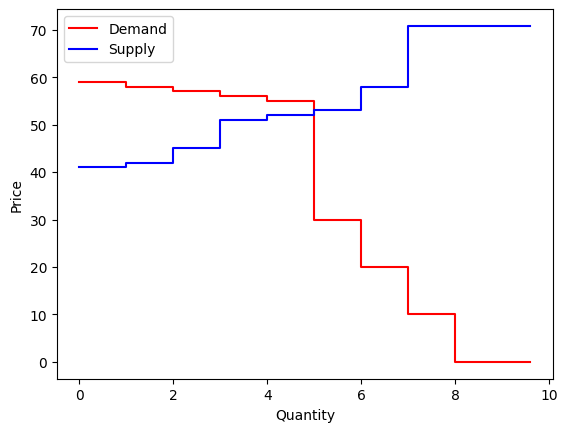

In [ ]:
bm.plot()